9.3 现代 cnn 架构.ipynb

一个模型的架构包含了创建这个模型所有因素

- 使用那些 layer?
- 如何配置所有 layer?
- 最后如何组合 layer?

这些选择定义了模型的假设空间.

假设空间相当于是模型的权重作为参数,模型梯度下降所有可能的搜索空间.

与特征工程一样,好的假设空间包含了我们对问题和解决方案的先验知识.例如,模型使用了卷积层,意味着你知道我们需要从输入图像寻找的模式具有平移不变性.

模型架构选择往往决定了能不能成功解决问题.不恰当的模型会卡死在次优指标,无论多少的训练数据都无法拯救.好的模型往往能有效利用数据,减少对数据的需求,更容易收敛到最优点.

如同特征工程和数据整理,模型架构选择也是为了梯度下降更加高效,尝试对梯度下降写入下面的印象: 梯度下降过程是个非常愚蠢的过程,尽一切可能去帮助它.

模型架构的选择更像是艺术而不是科学,有经验的工程师往往可以更有效率构建出高性能模型,而初学者连构建可训练模型都会非常吃力.虽然没有一个绝对的标准,但是还有工程上的最佳实践,可以供新手参考.

下面我们会回顾一些 cnn 架构的最佳实践,特别是残差连接(residual connections) 批量规范化(batch normalization) 可分离卷积(separable convolutions),当真正掌握这些架构时,才能高效的构建模型.我们会在猫狗的的分类上再次应用这些架构.


ps: ​[深度学习-关于图像分类的经典10篇文章](https://zhuanlan.zhihu.com/p/375444596) 对图像分类感兴趣可以看看这篇文章.


## MHR

如果有一个构造复杂系统的通用方法,那么一定是 MRH.MHR 代表了模块化 层次化 复用,几乎任何能看到架构这个词的地方都有 MRH.

如果你是一名软件工程师,那么 MRH 应该已经非常熟悉了.软件开发中会涉及大量模块/复用/层次化的内容.

说会深度学习本身,深度学习本身是利用梯度下降应用在了连续优化

- 我们使用了经典额优化技术 -> 在连续函数空间上的梯度下降.
- 将搜索空间结构归结为一个 layer
- 最终将 layer 组合成一个模型.
- 以上过程中我们可能复用任何东西

深度学习模型中,不仅有 layer 级别的复用,流行的架构中还包括模块级别的复用.一个例子就是上一节我们使用的 VGG16 模型.

大多数的 cmm 架构都有金字塔式的结构,上一章我们的模型中随着深度增加,cnn 输出特征图的深度也在不断增加.如下图的 VGG16 也是这样的架构.

![vgg16_pyramid](vgg16_pyramid.png)


深度越深,学习到的模式越有可能复用.一般而言,参数量相同情况下,深度更深的表现更好.但是深度更深带来了另一个问题 -> 梯度消失.这引出了我们的第一个基本架构--剩余连接.


### 消融实验

深度学习的架构往往是演化出来的,而不是设计出来的.不断反复尝试迭代最终得到成品,类似生物系统,有可能删除/替换一些模块而不会损失性能.

深度学习研究人员面临的问题更加复杂一些.如果可以使系统比必要更加复杂,会提高论坛通过同行评审的几率.很多深度学习的论文会针对同行评审优化,损害了解释的清晰和结果的可靠性.例如深度学习论文中的数学,很少被用来解释形式化概率和推理非显而易见的结果,反而被用来包装论文,像是推销员的昂贵西装.

研究的目的并不只是为了发表,而是为了可靠的知识.显而易见的,了解你系统中的因果关系,是产生知识的可靠途径.有一种非常省力的研究因果关系的方法--消融研究/消融实验(ablation studies)

消融实验: 类似控制变量,不断尝试去掉系统的不同部分,将系统简单化,查看其对性能的影响.确定那些部分对系统性能产生影响.

如果你要成为一名深度学习的研究人员,要不断尝试降低模型的复杂度--尝试进行消融实验.不断反问自己: 是否有更简单的解释?增加这个模块是否真的比较?


## 残差连接

残差连接对应的是解决梯度消失问题.

将深度学习看作是一连串的函数调用.

y = f4(f3(f2(f1(x))))

- 最终的输出是 f4 函数,我们要根据 f4 输出的误差记录调整整个链条所有函数的参数.计算反向传播就是这个过程.
- 整个链条上,每经过一个函数都会引入一定的噪声,随着函数链越来越长,总会出现梯度信息消失在了噪声中 -> 梯度消失问题.

既然梯度信息是在链上直线传播,一层一层的被削弱(让我想起了自动控制理论),那么改变这样的线性连接,使得无损的信息可以跨层传播呢?

残差连接就是这样的,将上一层或者模块的输入叠加回输出.使得无损的信息可以跨层传播.

![residual_connection](residual_connection.png)


In [ ]:
# x = ...
# residual = x
# x = block(x)
# x = add([x, residual])

简单情况下,残差连接如上所示.

输入叠加回输出意味着两者具有相同的形状,但是上一章提到的 cnn 层和最大池化层会改变输出的形状,这样的简单情况不再成立.


In [4]:
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)  #填充
residual = layers.Conv2D(64, 1)(residual)  # 不带激活函数 对输入进行处理 匹配输出
x = layers.add([x, residual])

cnn 层改变了输出形状

- `padding="same"` 防止宽高改变
- 不带激活的 Conv2D 处理深度轴的改变


In [3]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)  #填充
x = layers.MaxPooling2D(2, padding="same")(x)  #最大池化 下采样 x0.5
residual = layers.Conv2D(64, 1,
                         strides=2)(residual)  # 不带激活函数 步长2 下采样 x0.5 处理输入 匹配输出
x = layers.add([x, residual])

cnn 层+最大池化 改变了输出形状

- `padding="same"` 防止宽高改变
- 不带激活的 Conv2D 处理深度轴的改变.步长2 下采样对应最大池化下采样.


In [7]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.experimental.preprocessing.Rescaling(1. / 255)(inputs)  #数据转换


def residual_block(x, filters, pooling=False):  #模块
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:  #带最大池化
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x


x = residual_block(x, filters=32, pooling=True)  #使用了3个模块
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)  #全局平均值池化
outputs = layers.Dense(1, activation="sigmoid")(x)  #输出层
model = keras.Model(inputs=inputs, outputs=outputs)

这是一个可能的例子,复用了3次模块


In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 32, 32, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 32)   896         rescaling_1[0][0]                
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_21[0][0]                  
____________________________________________________________________________________________

模型结构,有点晕.

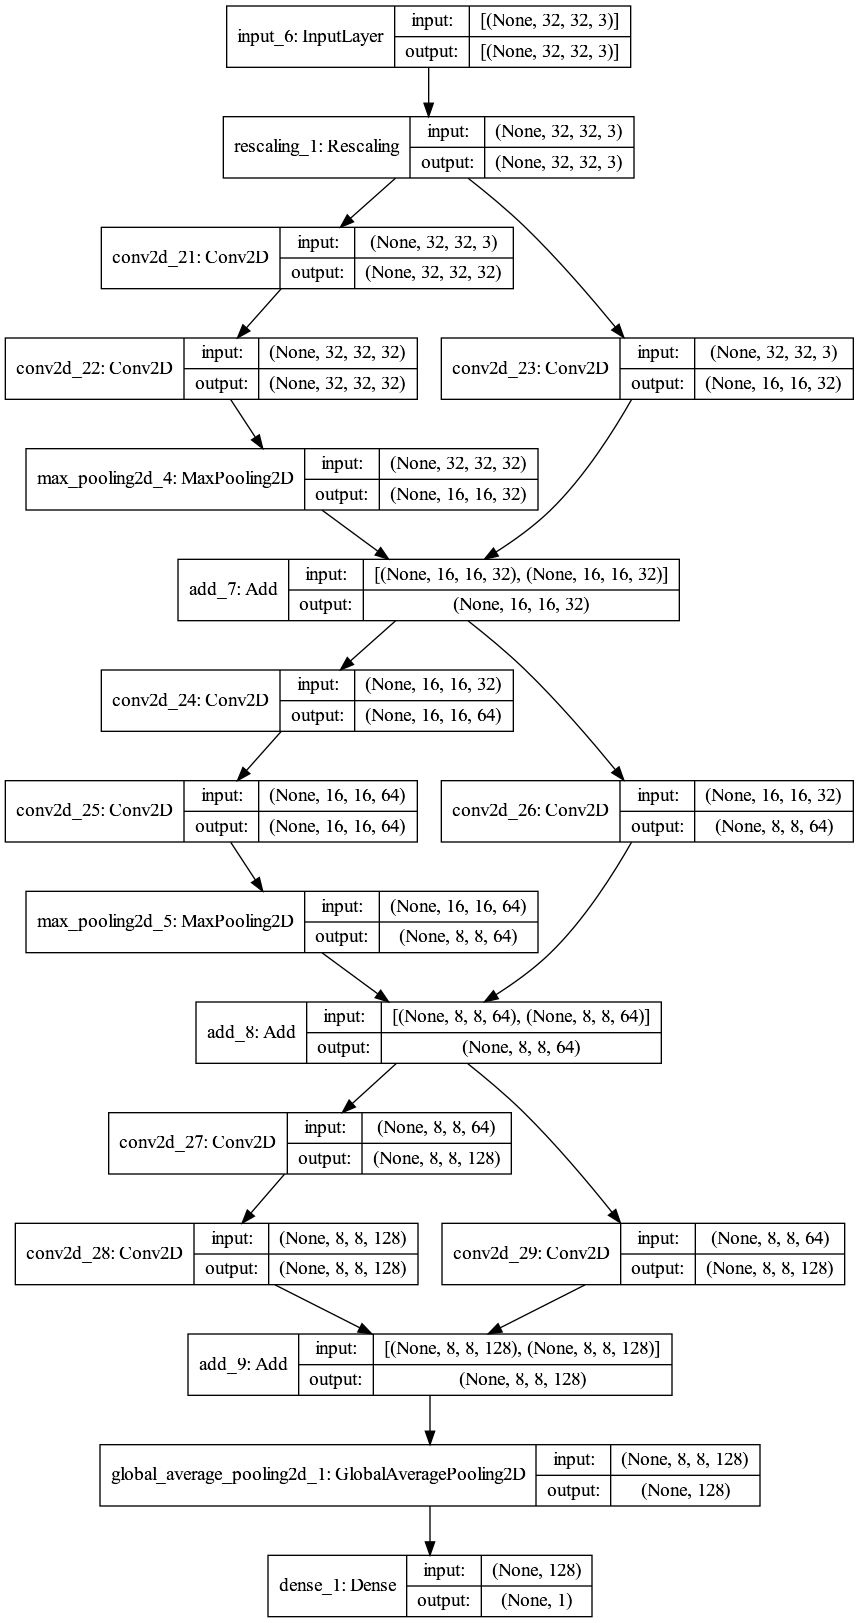

In [10]:
keras.utils.plot_model(model, "9.2.png", show_shapes=True)

可视化清楚多了.